# Elastic Compute - Process Notebook

http://harvard-team-pivot.github.io/elastic-compute/

Sean Keery

Rick Farmer

Robert Johnson

## Overview and Motivation

![Datacenter](http://harvard-team-pivot.github.io/elastic-compute/img/datacenter.jpg "Datacenter")
_(source: [topwalls.net](http://topwalls.net/server-data-center-lights-neon-computer-server-blue/))_

We are entering the age of the third platform in IT. The way we run applications is changing rapidly and significantly.

* **Platform Zero**
    > Apps were run on mainframes, but they were too big and too expensive.
* **Platform One**
    > Apps ran on commoditized computer hardware such as a PC, but this came with a high degree of waste. CPUs, memory and disk remained underutilized as single apps sat relatively idle to provide excess capacity for workloads that never came.
* **Platform Two**
    > Computers were virtualized so that several would be able to run at once on one hardware computer. This better used the CPU, memory, and disk of the inter-connected computers, thus creating a cloud of infrastructure resulting in much less waste.

The **Third Platform** moves the focus to driving business value and improving applications, instead of the increasing cost and infrastructure. We now virtualize applications into slices of CPU, memory, and disk of virtualized machines called containers. This process produces far less waste because the application containers can be spun-up or down in reaction to demand nearly instantly. We can scale applications to multiple nodes in places where capacity is available now, whether in Boston or Hong Kong. To scale well, applications are being redesigned as microservices, little units of work providing well-defined services to the whole of the modern distributed application.

The key element enabling this is capacity planning and load alerting for the container managed clusters. Do we need to scale now? If so, do we scale the app out because we need more resources to serve an avalanche of demand? Or do we scale in, because Black Friday has passed and our retail app no longer needs to use so many resources?

Our project is motivated to reduce waste by "right-sizing" energy consumption by linking it more directly to demand. Not many have seen the inside of a large Data Center, but these are colossal energy-hungry ventures [[1](http://harvard-team-pivot.github.io/elastic-compute/references.html)] on a scale that is difficult to appreciate without seeing one in person. Everything in a data center is planned around watt usage. About half of the wattage goes to server load and most of the rest to cooling equipment. If we can better predict and scale compute resource load more efficiently we have the opportunity to effect change in the United States alone at about the 9.1 TWhr (Terawatts per hour) level and, perhaps, slow the projected rise in consumption by 2020 to 13.9 TWhr [[2](http://harvard-team-pivot.github.io/elastic-compute/references.html)]. 


Our inferential goals are to understand how better to do capacity planning and alerting for microservice-based, container-managed clusters of compute resources. We would like to learn what makes a good alert threshold, such that we can predictably recommend actions that will keep an application highly available under various demand scenarios ranging from low to high. Effectively, we want to investigate the elasticity of supply and demand on compute resources so that we can make ongoing dynamic recommendations about the proper scale for a given set of inputs.

Benefits include:

* Learning what a low usage state is for applications and provide information on the scale (how many compute nodes) that should be set on a dynamic basis
* Reduction of energy usage by fitting the supply and demand more appropriately over time
* Elastic compute. The ability to prescriptively maintain application availability with the minimum amount of compute resources


## Related Work

The initial project proposal was in part inspired based off of this blog post from Pivotal Labs "Multivariate Time Series Forecasting for Virtual Machine and Capacity Planning": 

https://blog.pivotal.io/data-science-pivotal/products/multivariate-time-series-forecasting-for-virtual-machine-capacity-planning

For CSCI E-63, Big Data Analytics, offered through the Harvard Extension School, Sean Keery worked on a similar project on PaaS Energy Efficiency. Links to his work can be found below: 

<b>Project Presentation:</b> https://www.youtube.com/watch?v=_IkLNczcaWA

<b>Demo:</b> https://www.youtube.com/watch?v=4gshfs6WqnQ


## Initial Questions

The next level of consolidation in the third platform will occur through application virtualization.  Our goal was to identify how we could concentrate workloads to reduce energy consumption, so we began looking for application data we could use to identify patterns.  We were able to get a number of applications running on Pivotal Web Services.  We added application performance monitoring by binding all our microservices to a free trial of New Relic.   The New Relic suite is superb at tracking web and service transaction metrics such as response time and throughput.  However, after initial exploration, we found it very difficult to export the data in a way that we could identify individual application utilization.


![New Relic](http://harvard-team-pivot.github.io/elastic-compute/visualizations/apm-app-new-relic-server-breakdown.png "New Relic")
￼

Next we got a free subscription to DataDog.  We found the metrics were too high level for what we needed.  They tended to be at the host/server level.


![DataDog](http://harvard-team-pivot.github.io/elastic-compute/visualizations/apm-firehose.png "DataDog")
￼

Since each application runs in it’s own container, we thought we could get equivalent data from a container solution.  Coincidentally, we were given a demo of an internal Pivotal APM tool.


￼![Firehose nozzle container-level metrics](http://harvard-team-pivot.github.io/elastic-compute/visualizations/apm-container-metrics-utilization.png "Firehose nozzle container-level metrics")


Although the product was not available, we found we were able to obtain container level metrics through a command line interface through the same application “nozzle” that this beautiful dashboard was using.
￼We installed a plugin that would export the metrics following the instructions at this site.  Then we ran the following commands `cf nozzle -f ContainerMetric > ContainerMetricPaaS4.txt` , `cf nozzle -f ValueMetric > valueMetricSaaS2.txt` which piped the output to a file.  

## Exploratory Data Analysis

First, we will impored python libararies: NumPy, SciPy, matplotlib, pandas, and Seaborn. 
All of our color selections were from http://colorbrewer2.org/, a project from Pennsylvania State University designed to improve color palettes on maps and charts.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

We will read in our data below: 

In [1]:
container_PaaS_data=open('data/ContainerMetricPaaS.txt').read()
container_SaaS_data=open('data/ContainerMetricSaas.txt').read()
large_container_SaaS_data=open('data/ContainerMetricSaaS2.txt').read()
large_container_PaaS_data=open('data/ContainerMetricPaaS2.txt').read()
value_PaaS_data=open('data/valueMetricPaaS.txt').read()
value_SaaS_data=open('data/valueMetricSaaS.txt').read()
large_value_SaaS_data=open('data/valueMetricSaaS2.txt').read()

Our data is currently semi-structured and in order to perform analysis in the notebook we will translate our data into pandas dataframes, using our simple parsing functions <b>container_clean</b> and <b>value_clean</b>, which are to be used for container data and value data respectively.

In [3]:
"""
Function
--------
container_clean

Inputs
------
data: a subset of Pivotal container data
   
Returns
-------

A Pandas dataframe containing the attributes of the semi-strucutred data passed in. 


Notes
-----
See description and example above.
"""


def container_clean(data):
    
    inDataSplit = data.split(" ")
    originList = [] 
    eventTypeList = []
    timestampList = []
    deployList = []
    jobList = []
    indexList = []
    ipList = []
    appIDList = []
    instanceList = []
    cpuList = []
    memoryList = []
    diskList = []
    
    for item in inDataSplit:
        if "origin:" in item:
            origin = item.replace(">\r\n\r\norigin:","")
            if "\n\norigin:" in origin: 
                origin = item.replace("\n\norigin:","")
            if "exit\norigin:" in origin: 
                origin = item.replace("exit\norigin:","")
            originList.append(origin)
        if "eventType:" in item:
            eventType = item.replace("eventType:","")
            eventTypeList.append(eventType)
        if "timestamp:" in item:
            timestamp = int(item.replace("timestamp:",""))
            timestampList.append(timestamp)
        if "deployment:" in item:
            deployment = item.replace("deployment:","")
            deployList.append(deployment)
        if 'job:' in item:
            job = item.replace("job:","")
            jobList.append(job)
        if 'index:' in item:
            index = item.replace("index:","")
            indexList.append(index)
        if 'ip:' in item:
            ip = item.replace("ip:","")
            ipList.append(ip)
        if 'applicationId:' in item:
            applicationId = item.replace("containerMetric:<applicationId:","")
            appIDList.append(applicationId)
        if 'instanceIndex:' in item:
            instanceIndex = float(item.replace("instanceIndex:",""))
            instanceList.append(instanceIndex)
        if 'cpuPercentage:' in item:
            cpuPercentage = float(item.replace("cpuPercentage:",""))
            cpuList.append(cpuPercentage)
        if 'memoryBytes:' in item:
            memoryBytes = float(item.replace("memoryBytes:",""))
            memoryList.append(memoryBytes)
        if 'diskBytes:' in item:
            diskBytes = float(item.replace("diskBytes:",""))
            diskList.append(diskBytes)


    dataDict = {"origin":originList,"event_type":eventTypeList,"timestamp":timestampList,"deployment":deployList,"job":jobList,
           "index": indexList,"ip_address":ipList,"applicationID":appIDList,"instance_index":instanceList,
           "cpu_percentage":cpuList,"memory_bytes":memoryList, "disk_bytes":diskList}

    returnDF = pd.DataFrame(dataDict)
    returnDF.index = returnDF["timestamp"]
    returnDF = returnDF.drop("timestamp", axis = 1)
    return returnDF


In [4]:
"""
Function
--------
value_clean

Inputs
------
data: a subset of Pivotal value data
   
Returns
-------

A Pandas dataframe containing the attributes of the semi-strucutred data passed in. 


Notes
-----
See description and example above.
"""

def value_clean(data):
    
    inDataSplit = data.split(" ")
    originList = [] 
    eventTypeList = []
    timestampList = []
    deployList = []
    jobList = []
    indexList = []
    ipList = []
    nameList = []
    valueList = []
    unitList = []

    
    for item in inDataSplit:
        if "origin:" in item:
            origin = item.replace("\norigin:","")
            if "exit" in origin:
                origin = origin.replace("exit","")
            if "\n" in origin:
                origin = origin.replace("\n","")
            originList.append(origin)
        if "eventType:" in item:
            eventType = item.replace("eventType:","")
            eventTypeList.append(eventType)
        if "timestamp:" in item:
            timestamp = int(item.replace("timestamp:",""))
            timestampList.append(timestamp)
        if "deployment:" in item:
            deployment = item.replace("deployment:","")
            deployList.append(deployment)
        if 'job:' in item:
            job = item.replace("job:","")
            jobList.append(job)
        if 'index:' in item:
            index = item.replace("index:","")
            indexList.append(index)
        if 'ip:' in item:
            ip = item.replace("ip:","")
            ipList.append(ip)
        if 'name:' in item:
            nameId = item.replace("valueMetric:<name:","")
            nameList.append(nameId)
        if 'value:' in item:
            value = float(item.replace("value:",""))
            valueList.append(value)
        if 'unit:' in item:
            unit = item.replace("unit:","")
            unitList.append(unit)    
        

    dataDict = {"origin":originList,"event_type":eventTypeList,"timestamp":timestampList,"deployment":deployList,"job":jobList,
           "index": indexList,"ip_address":ipList,"name":nameList,"value":valueList, "unit":unitList}

    returnDF = pd.DataFrame(dataDict)
    returnDF.index = returnDF["timestamp"]
    returnDF = returnDF.drop("timestamp", axis = 1)
    return returnDF


Our functions will be used on our data sets, creating **need final number** total data frames: three for container data and three for value data. 

In [7]:
container_IaaSDF = container_clean(container_IaaS_data)
container_PaaSDF = container_clean(container_PaaS_data)
container_SaaSDF = container_clean(container_SaaS_data)
large_container_SaaSDF = container_clean(large_container_SaaS_data)
large_container_PaaSDF = container_clean(large_container_PaaS_data)

value_IaaSDF = value_clean(value_IaaS_data)
value_PaaSDF = value_clean(value_PaaS_data)
value_SaaSDF = value_clean(value_SaaS_data)
large_value_SaaSDF = value_clean(large_value_SaaS_data)


We will export our large data sets to csvs for usage with Tableau.

In [6]:
large_container_SaaSDF.to_csv("ContainerMetricSaaS2.csv")
large_value_SaaSDF.to_csv("valueMetricSaaS2.csv")

Below is an example of a container data frame and an example of a value data frame.

In [8]:
container_PaaSDF.head()

,applicationID,cpu_percentage,deployment,disk_bytes,event_type,index,instance_index,ip_address,job,memory_bytes,origin
timestamp,,,,,,,,,,,
1448757452182774182,"""784c0af0-9c20-4d27-90ca-9b467b009a32""",0.179657,"""cf""",69152768,ContainerMetric,"""1""",2,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",9949184,"""rep"""
1448757452182821978,"""784c0af0-9c20-4d27-90ca-9b467b009a32""",0.200273,"""cf""",69169152,ContainerMetric,"""1""",1,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",15273984,"""rep"""
1448757452182848459,"""b1138b50-eff3-4aca-abfd-f96ff1acf6f1""",0.023017,"""cf""",93200384,ContainerMetric,"""1""",0,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",62615552,"""rep"""
1448757452182872351,"""b1aca68a-19a7-4b4d-aeb1-accf3cff5dca""",0.085007,"""cf""",162201600,ContainerMetric,"""1""",0,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",312029184,"""rep"""
1448757452182890660,"""de712236-f466-4852-bcee-d06fb7e2a7a5""",0.031018,"""cf""",68833280,ContainerMetric,"""1""",0,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",14073856,"""rep"""


In [7]:
value_PaaSDF.head()

,deployment,event_type,index,ip_address,job,name,origin,unit,value
timestamp,,,,,,,,,
1448757347152847149,"""cf""",ValueMetric,"""0""","""10.0.16.26""","""doppler-partition-f99bec444d276db0e93a""","""messageRouter.numberOfFirehoseSinks""","""DopplerServer""","""sinks""",1
1448757347472961124,"""cf""",ValueMetric,"""0""","""10.0.16.22""","""diego_brain-partition-f99bec444d276db0e93a""","""logSenderTotalMessagesRead""","""route_emitter""","""count""",0
1448757347473020422,"""cf""",ValueMetric,"""0""","""10.0.16.22""","""diego_brain-partition-f99bec444d276db0e93a""","""numCPUS""","""route_emitter""","""count""",1
1448757347473030741,"""cf""",ValueMetric,"""0""","""10.0.16.22""","""diego_brain-partition-f99bec444d276db0e93a""","""numGoRoutines""","""route_emitter""","""count""",69
1448757347473107003,"""cf""",ValueMetric,"""0""","""10.0.16.22""","""diego_brain-partition-f99bec444d276db0e93a""","""memoryStats.numBytesAllocatedHeap""","""route_emitter""","""count""",1691560


Now, we can begin to explore some of our data. Let's take a look at some basic descriptive statistics to get started.

In [12]:
print "SaaS Container Summary Statistics"
print large_container_SaaSDF.describe()
print large_container_SaaSDF.corr()
print "PaaS Container Summary Statistics"
print large_container_PaaSDF.describe()
print large_container_PaaSDF.corr()

IaaS Container Summary Statistics
       cpu_percentage    disk_bytes  instance_index  memory_bytes
count       43.000000  4.300000e+01       43.000000  4.300000e+01
mean         0.192954  1.346400e+08        0.209302  1.428090e+08
std          0.419780  6.467369e+07        0.558831  2.069358e+08
min          0.000000  5.200691e+07        0.000000  9.949184e+06
25%          0.022879  6.915277e+07        0.000000  1.527398e+07
50%          0.072005  1.552220e+08        0.000000  7.622656e+07
75%          0.185923  1.622016e+08        0.000000  1.279877e+08
max          1.951099  2.866545e+08        2.000000  7.861084e+08
                cpu_percentage  disk_bytes  instance_index  memory_bytes
cpu_percentage        1.000000    0.580495        0.001539     -0.044228
disk_bytes            0.580495    1.000000       -0.388244      0.518584
instance_index        0.001539   -0.388244        1.000000     -0.242901
memory_bytes         -0.044228    0.518584       -0.242901      1.000000

PaaS C

Just to get a sense of general performance across the different services, we will plot the three different readings: memory usage, disk usage, and CPU utilization. For easy readibility, we have removed the exact timestamps from our x-axis.  

[]

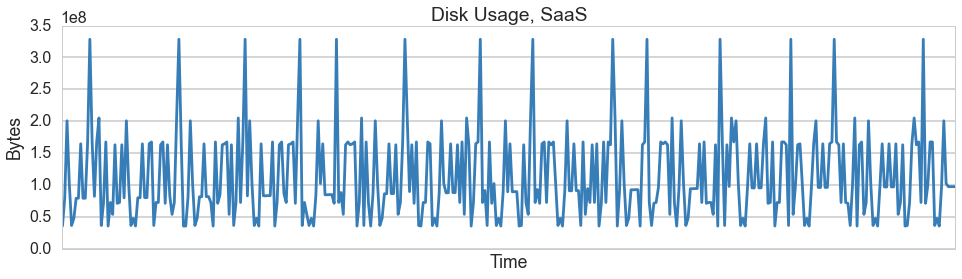

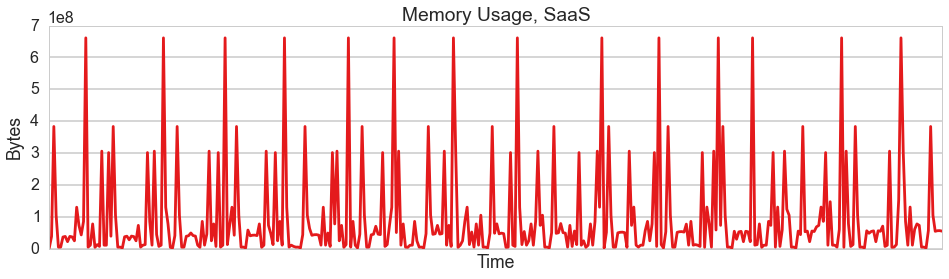

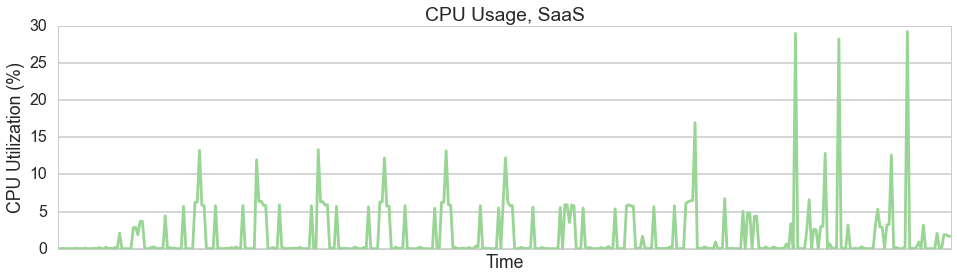

In [13]:
fig0, axes0 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
fig2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

ax = sns.tsplot(large_container_SaaSDF.disk_bytes, color = "#377eb8", ax = axes0)
ax.set_title("Disk Usage, SaaS")
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
ax.get_xaxis().set_ticks([])

ax1 = sns.tsplot(large_container_SaaSDF.memory_bytes, color = "#e41a1c", ax = axes1)
ax1.set_title("Memory Usage, SaaS")
ax1.set_ylabel("Bytes")
ax1.set_xlabel("Time")
ax1.get_xaxis().set_ticks([])

ax2 = sns.tsplot(large_container_SaaSDF.cpu_percentage, color = "#99d594", ax = axes2)
ax2.set_title("CPU Usage, SaaS")
ax2.set_ylabel("CPU Utilization (%)")
ax2.set_xlabel("Time")
ax2.get_xaxis().set_ticks([])

[]

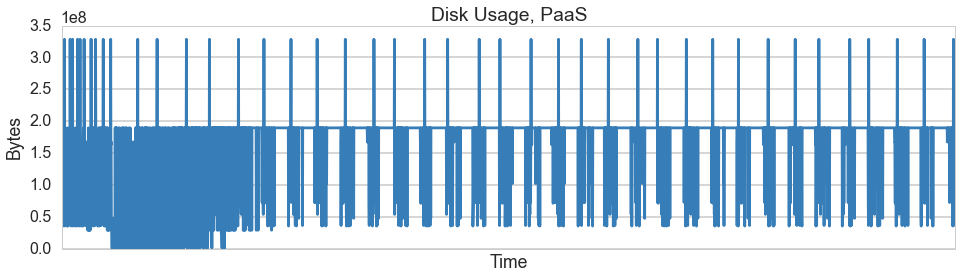

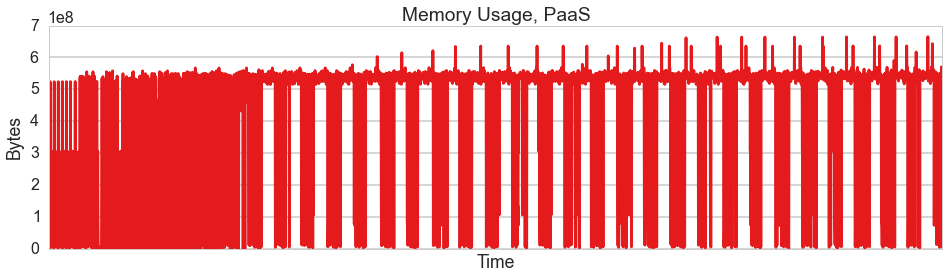

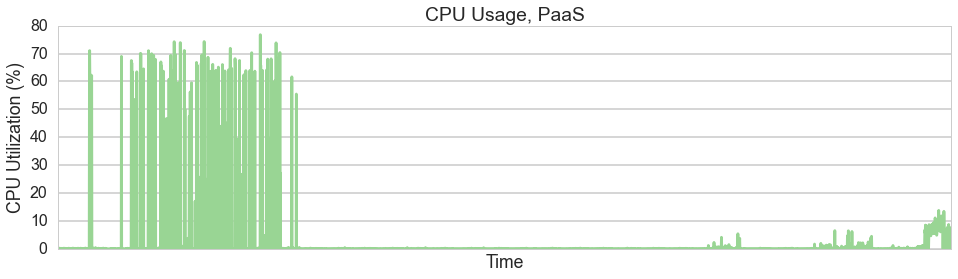

In [11]:
fig0, axes0 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
fig2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

ax = sns.tsplot(large_container_PaaSDF.disk_bytes, color = "#377eb8", ax = axes0)
ax.set_title("Disk Usage, PaaS")
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
ax.get_xaxis().set_ticks([])

ax1 = sns.tsplot(large_container_PaaSDF.memory_bytes, color = "#e41a1c", ax = axes1)
ax1.set_title("Memory Usage, PaaS")
ax1.set_ylabel("Bytes")
ax1.set_xlabel("Time")
ax1.get_xaxis().set_ticks([])

ax2 = sns.tsplot(large_container_PaaSDF.cpu_percentage, color = "#99d594", ax = axes2)
ax2.set_title("CPU Usage, PaaS")
ax2.set_ylabel("CPU Utilization (%)")
ax2.set_xlabel("Time")
ax2.get_xaxis().set_ticks([])

We can take a look at the summary statistics for our value data as well.

In [14]:
print "PaaS Value Summary Statistics"
print value_PaaSDF['value'].describe()
print ""
print "SaaS Value Summary Statistics"
print value_SaaSDF['value'].describe()

IaaS Value Summary Statistics
count    1.564000e+03
mean     5.256601e+07
std      4.064148e+08
min      0.000000e+00
25%      8.000000e+00
50%      6.900000e+01
75%      6.991430e+05
max      4.944930e+09
Name: value, dtype: float64

PaaS Value Summary Statistics
count    1.628000e+03
mean     5.213784e+07
std      3.990171e+08
min      0.000000e+00
25%      8.000000e+00
50%      7.700000e+01
75%      7.043428e+05
max      4.943411e+09
Name: value, dtype: float64

SaaS Value Summary Statistics
count    1.354400e+04
mean     9.139879e+06
std      1.666479e+08
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.994340e+09
Name: value, dtype: float64


Let's take a look at our container data again, this time grouped by appliation type. 

In [14]:
container_IaaSDF_group = container_IaaSDF.groupby("applicationID")
container_PaaSDF_group = container_PaaSDF.groupby("applicationID")
container_SaaSDF_group = container_SaaSDF.groupby("applicationID")    
large_container_SaaSDF_group = large_container_SaaSDF.groupby("applicationID")
large_container_PaaSDF_group = large_container_PaaSDF.groupby("applicationID")

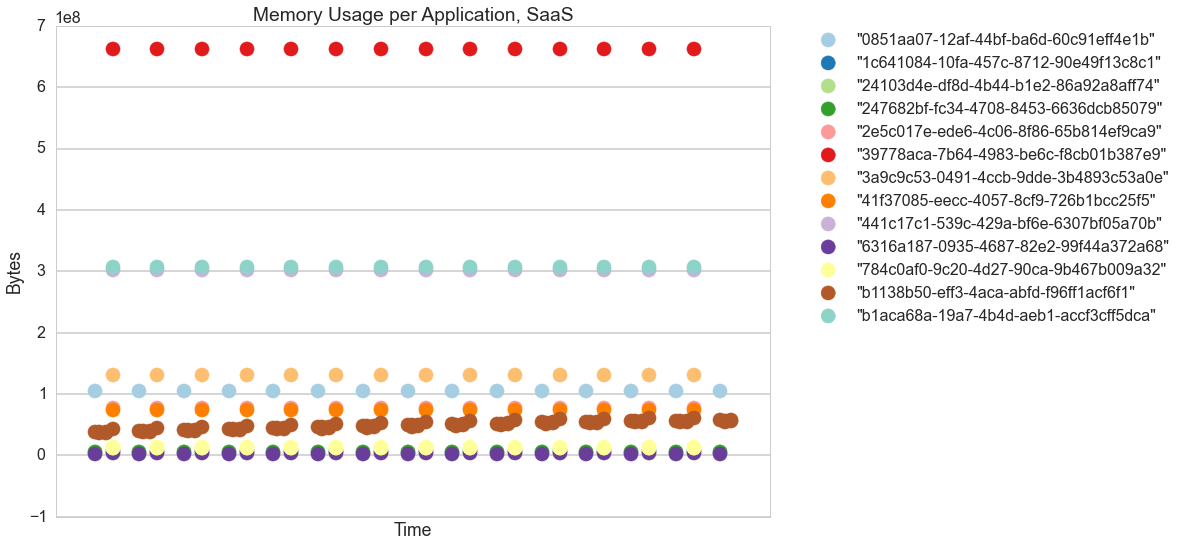

In [18]:
app_palette= ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a',
                       '#ffff99','#b15928','#8dd3c7']
appname_list = []
for appname, values in large_container_SaaSDF_group: 
    name = str(appname)
    appname_list.append(name)

app_color_list = zip(appname_list,app_palette)    

    
for name,color in app_color_list:
    sub_container=large_container_SaaSDF[large_container_SaaSDF.applicationID== name]
    ax= plt.scatter(sub_container.index.values,sub_container.memory_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Memory Usage per Application, SaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

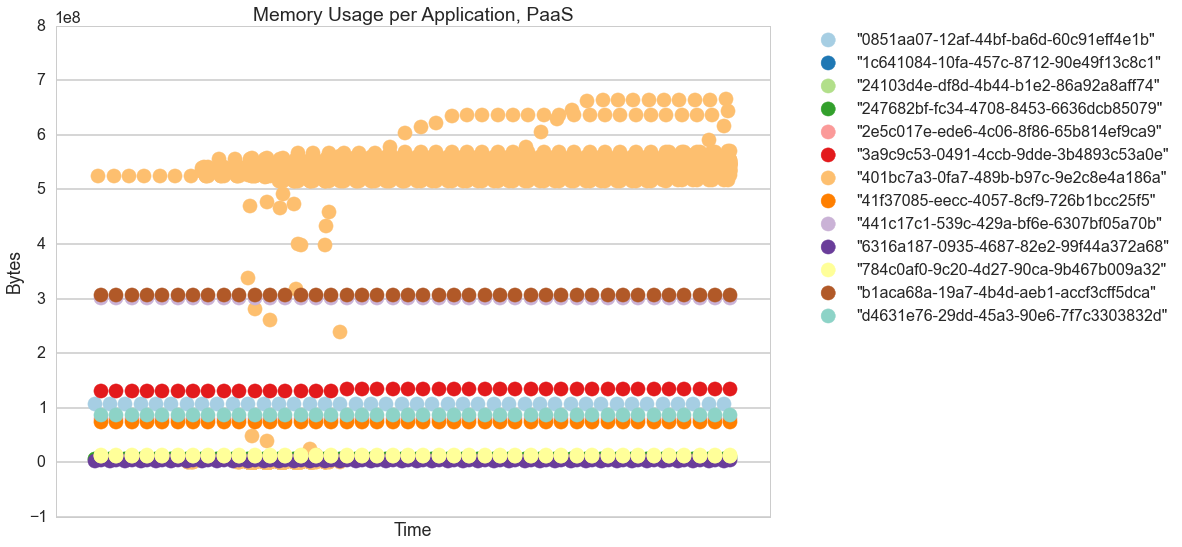

In [16]:
app_palette= ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a',
                       '#ffff99','#b15928','#8dd3c7']
appname_list = []
for appname, values in large_container_PaaSDF_group: 
    name = str(appname)
    appname_list.append(name)

app_color_list = zip(appname_list,app_palette)    

    
for name,color in app_color_list:
    sub_container=large_container_PaaSDF[large_container_PaaSDF.applicationID== name]
    ax= plt.scatter(sub_container.index.values,sub_container.memory_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Memory Usage per Application, PaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

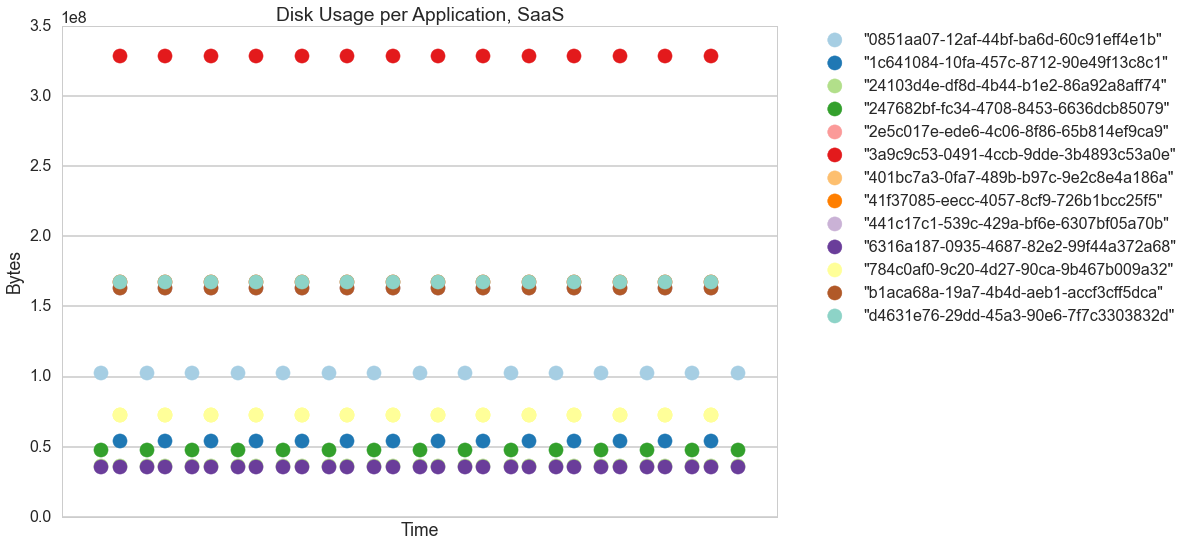

In [17]:
for name,color in app_color_list:
    sub_container=large_container_SaaSDF[large_container_SaaSDF.applicationID== name]
    plt.scatter(sub_container.index.values,sub_container.disk_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Disk Usage per Application, SaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

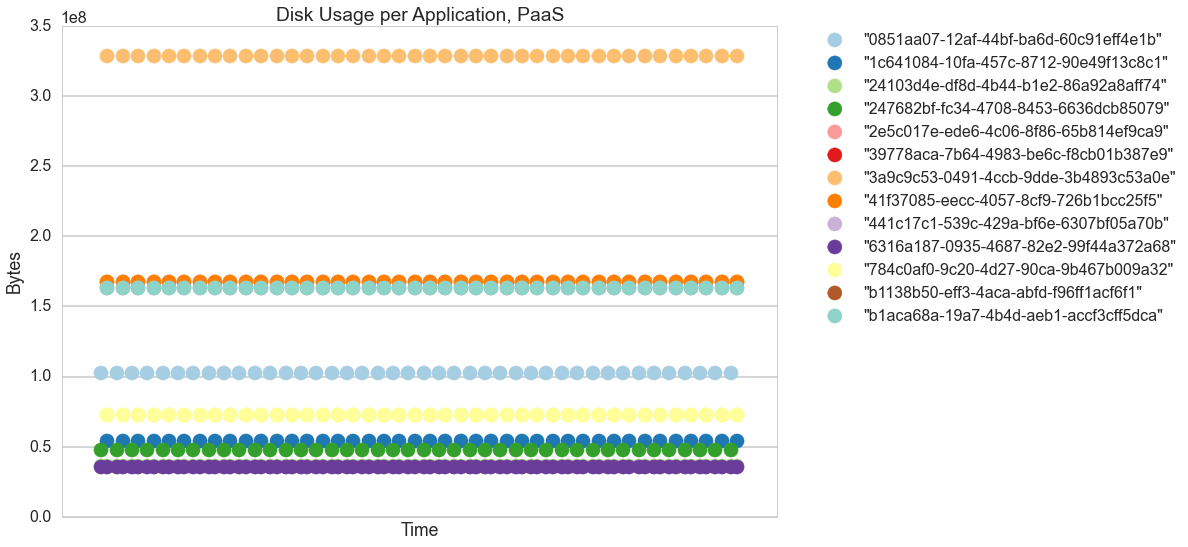

In [19]:
for name,color in app_color_list:
    sub_container=large_container_PaaSDF[large_container_PaaSDF.applicationID== name]
    plt.scatter(sub_container.index.values,sub_container.disk_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Disk Usage per Application, PaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

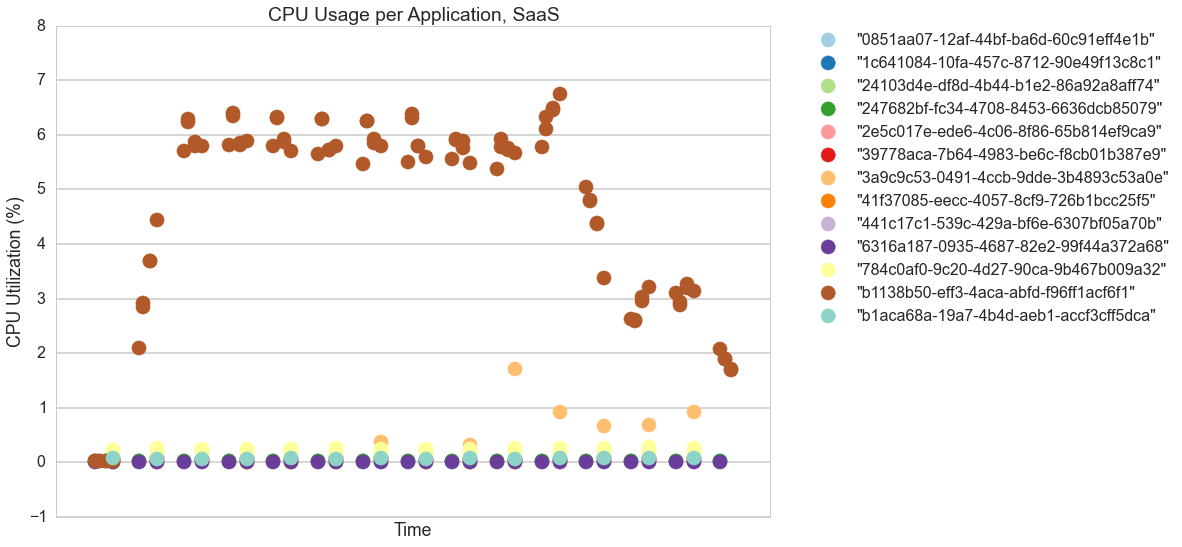

In [22]:
for name,color in app_color_list:
    sub_container=large_container_SaaSDF[large_container_SaaSDF.applicationID== name]
    ax= plt.scatter(sub_container.index.values,sub_container.cpu_percentage,color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("CPU Utilization (%)")
    plt.title("CPU Usage per Application, SaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

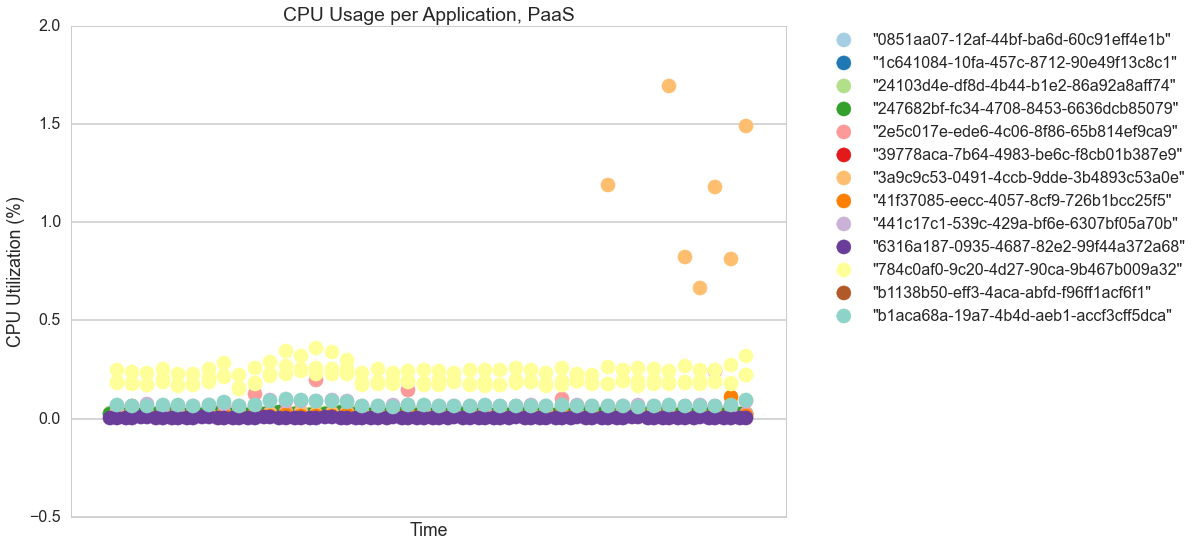

In [21]:
for name,color in app_color_list:
    sub_container=large_container_PaaSDF[large_container_PaaSDF.applicationID== name]
    ax= plt.scatter(sub_container.index.values,sub_container.cpu_percentage,color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("CPU Utilization (%)")
    plt.title("CPU Usage per Application, PaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

We can also examine which IP addresses are using the most resources. 

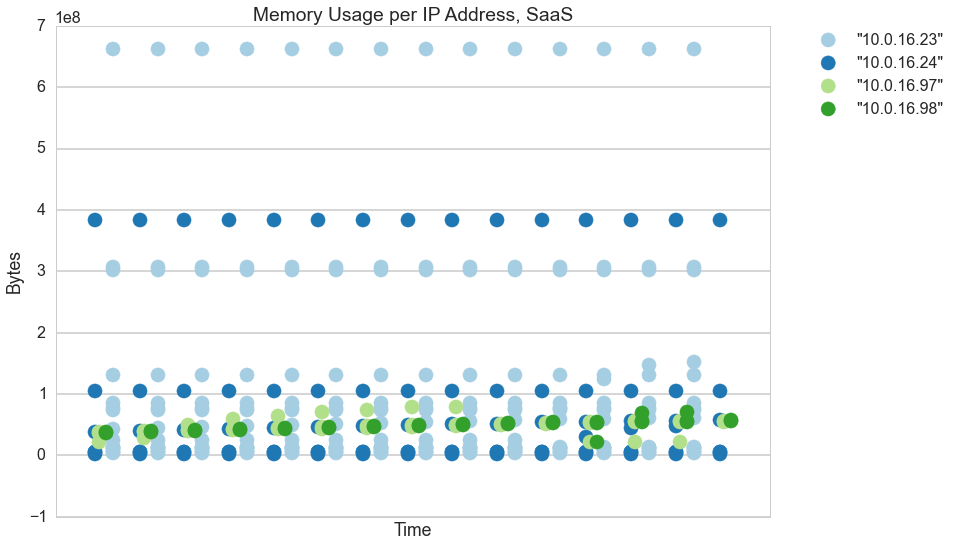

In [36]:
large_container_SaaSDF_group_IP = large_container_SaaSDF.groupby("ip_address")

ip_palette= ['#a6cee3','#1f78b4','#b2df8a','#33a02c']

ipname_list = []
for ipname, values in large_container_SaaSDF_group_IP: 
    name = str(ipname)
    ipname_list.append(name)

ip_color_list = zip(ipname_list,ip_palette)    

    
for name,color in ip_color_list:
    sub_container=large_container_SaaSDF[large_container_SaaSDF.ip_address== name]
    ax= plt.scatter(sub_container.index.values,sub_container.memory_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Memory Usage per IP Address, SaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

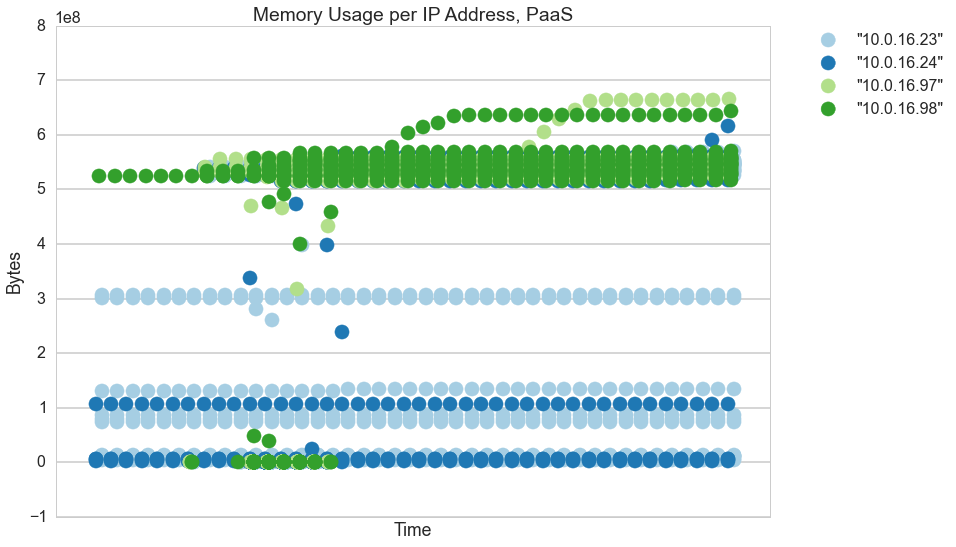

In [33]:
large_container_PaaSDF_group_IP = large_container_PaaSDF.groupby("ip_address")

ip_palette= ['#a6cee3','#1f78b4','#b2df8a','#33a02c']

ipname_list = []
for ipname, values in large_container_PaaSDF_group_IP: 
    name = str(ipname)
    ipname_list.append(name)

ip_color_list = zip(ipname_list,ip_palette)    

    
for name,color in ip_color_list:
    sub_container=large_container_PaaSDF[large_container_PaaSDF.ip_address== name]
    ax= plt.scatter(sub_container.index.values,sub_container.memory_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Memory Usage per IP Address, PaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

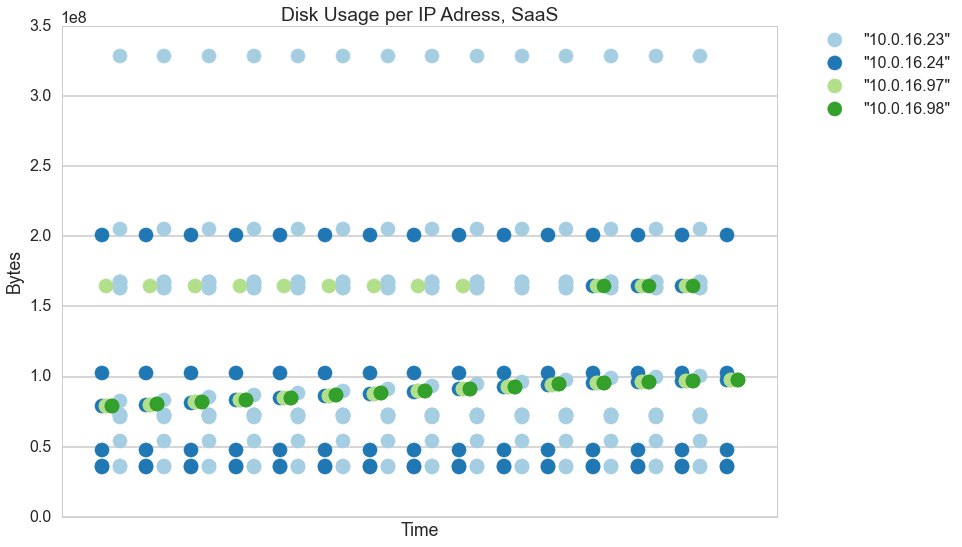

In [35]:
for name,color in ip_color_list:
    sub_container=large_container_SaaSDF[large_container_SaaSDF.ip_address== name]
    ax= plt.scatter(sub_container.index.values,sub_container.disk_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Disk Usage per IP Adress, SaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

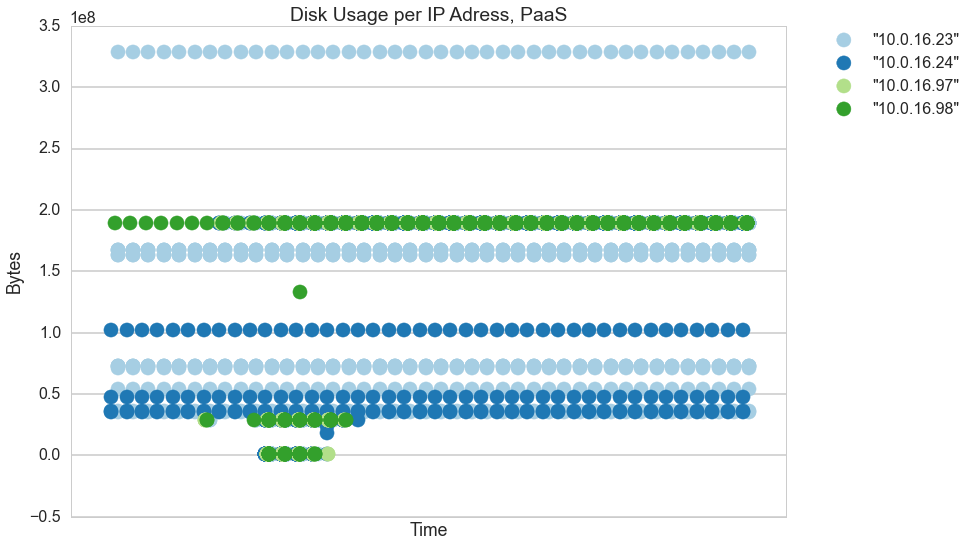

In [32]:
for name,color in ip_color_list:
    sub_container=large_container_PaaSDF[large_container_PaaSDF.ip_address== name]
    ax= plt.scatter(sub_container.index.values,sub_container.disk_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Disk Usage per IP Adress, PaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

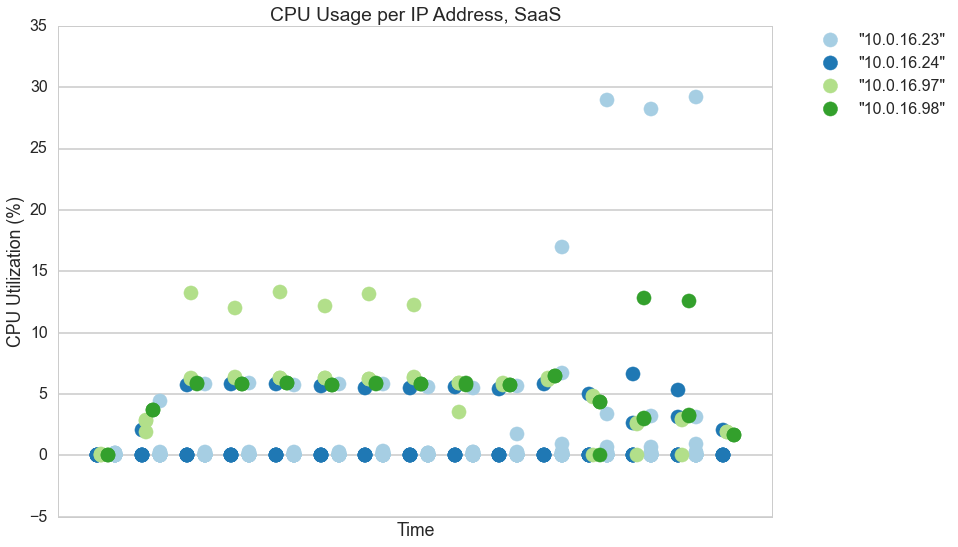

In [34]:
for name,color in ip_color_list:
    sub_container=large_container_SaaSDF[large_container_SaaSDF.ip_address== name]
    ax= plt.scatter(sub_container.index.values,sub_container.cpu_percentage, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("CPU Utilization (%)")
    plt.title("CPU Usage per IP Address, SaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

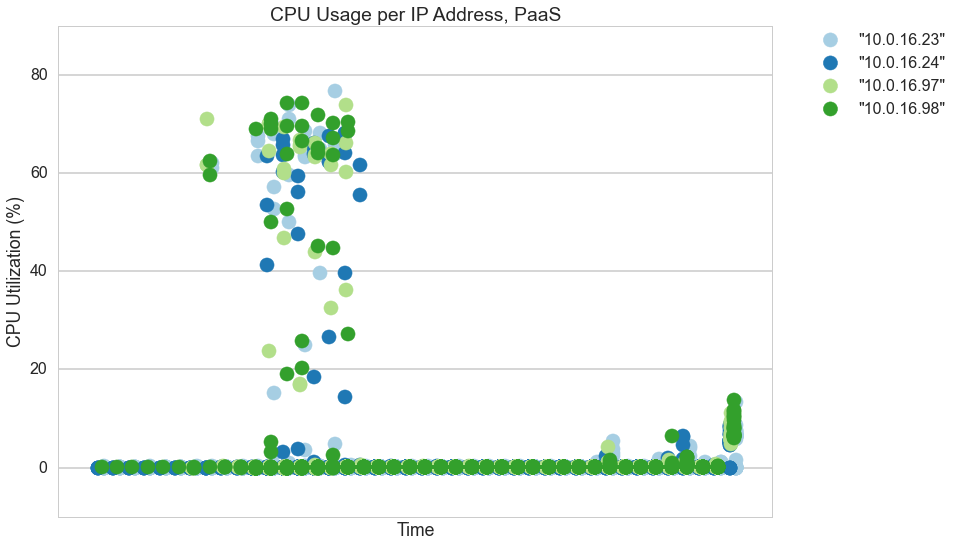

In [31]:
for name,color in ip_color_list:
    sub_container=large_container_PaaSDF[large_container_PaaSDF.ip_address== name]
    ax= plt.scatter(sub_container.index.values,sub_container.cpu_percentage, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("CPU Utilization (%)")
    plt.title("CPU Usage per IP Address, PaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

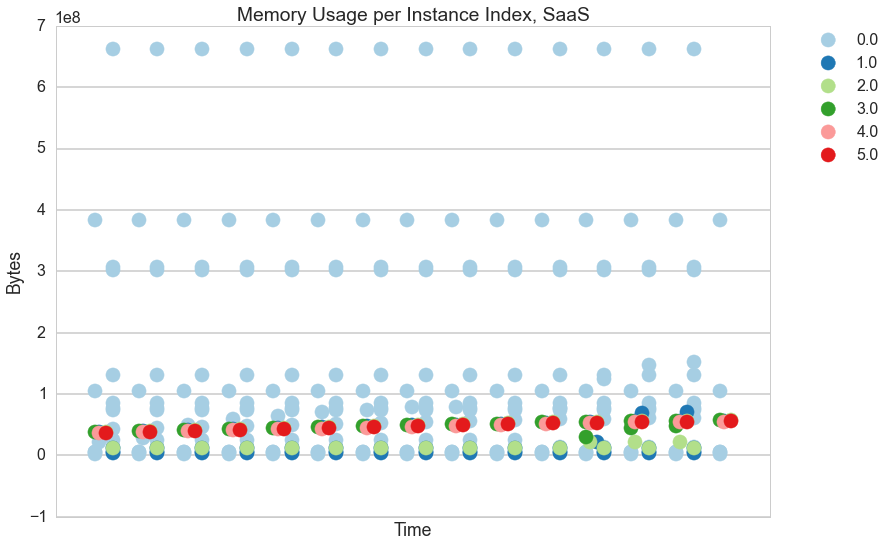

In [33]:
large_container_SaaSDF_group_index = large_container_SaaSDF.groupby("instance_index")


index_palette= ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

indexname_list = []
for index, values in large_container_SaaSDF_group_index: 
    i = index
    indexname_list.append(i)

index_color_list = zip(indexname_list,index_palette)    


for name,color in index_color_list:
    sub_container=large_container_SaaSDF[large_container_SaaSDF.instance_index == name]
    ax= plt.scatter(sub_container.index.values,sub_container.memory_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Memory Usage per Instance Index, SaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


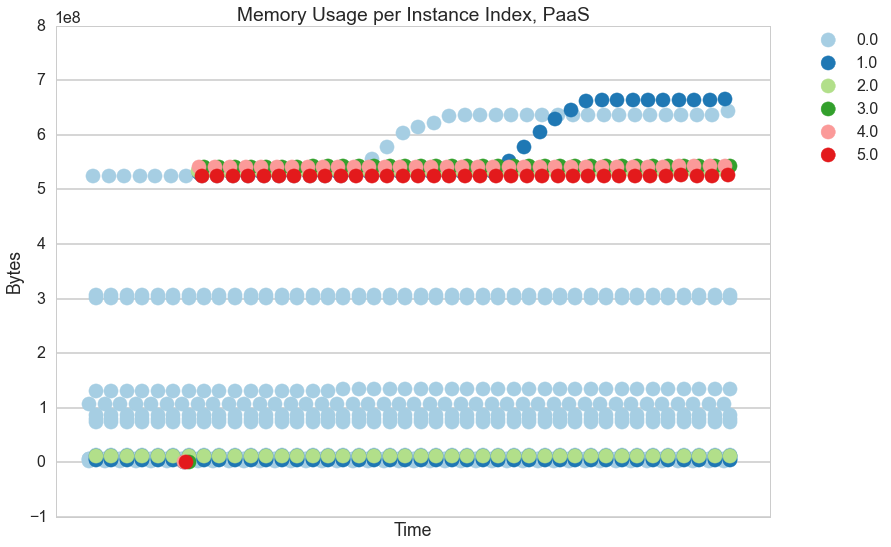

In [30]:
large_container_PaaSDF_group_index = large_container_PaaSDF.groupby("instance_index")


index_palette= ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

indexname_list = []
for index, values in large_container_PaaSDF_group_index: 
    i = index
    indexname_list.append(i)

index_color_list = zip(indexname_list,index_palette)    


for name,color in index_color_list:
    sub_container=large_container_PaaSDF[large_container_PaaSDF.instance_index == name]
    ax= plt.scatter(sub_container.index.values,sub_container.memory_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Memory Usage per Instance Index, PaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

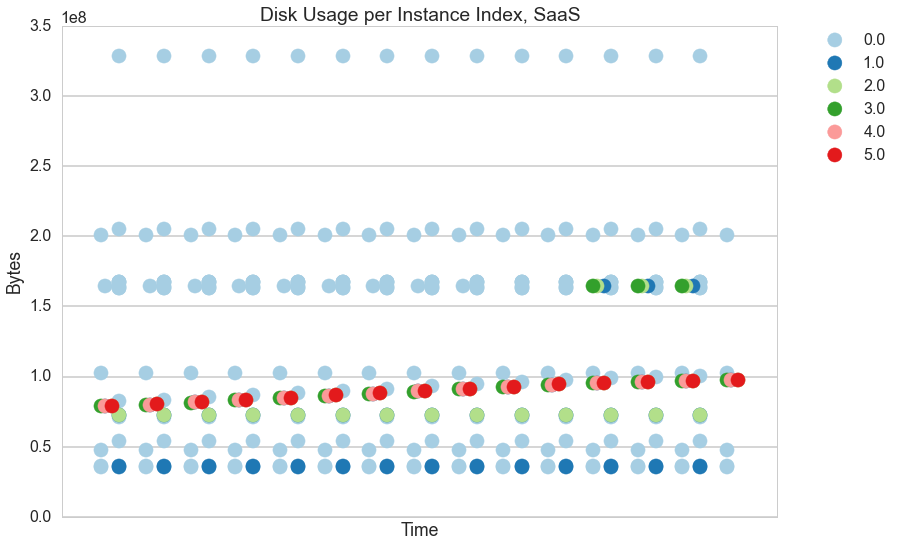

In [26]:
for name,color in index_color_list:
    sub_container=large_container_SaaSDF[large_container_SaaSDF.instance_index == name]
    ax= plt.scatter(sub_container.index.values,sub_container.disk_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Disk Usage per Instance Index, SaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

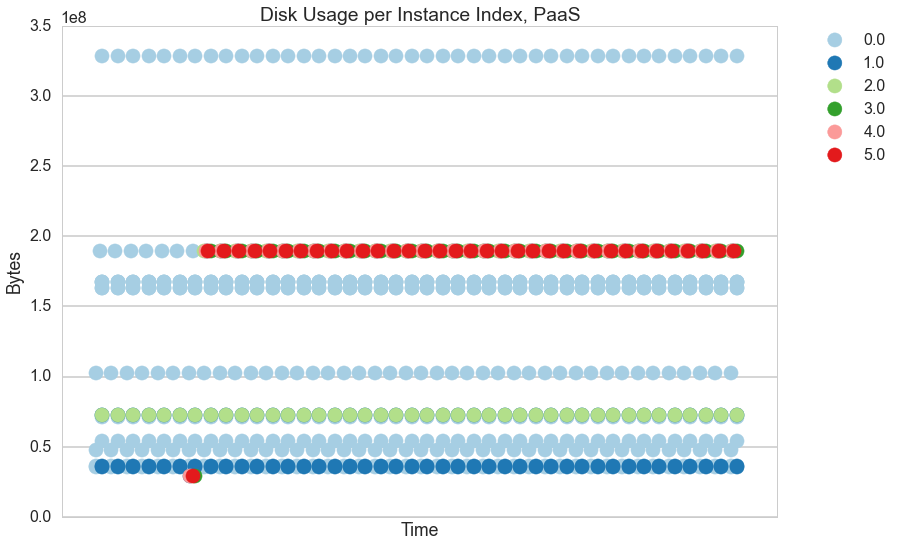

In [29]:
for name,color in index_color_list:
    sub_container=large_container_PaaSDF[large_container_PaaSDF.instance_index == name]
    ax= plt.scatter(sub_container.index.values,sub_container.disk_bytes, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("Bytes")
    plt.title("Disk Usage per Instance Index, PaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

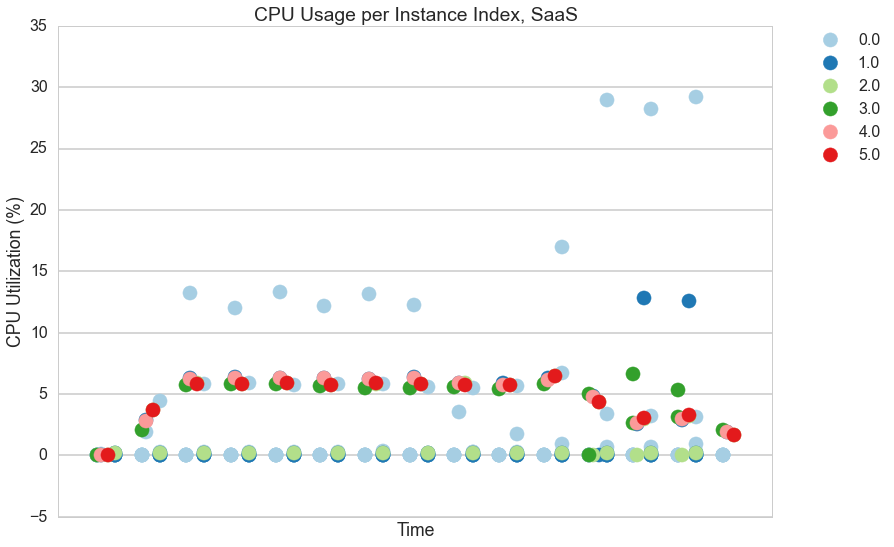

In [27]:
for name,color in index_color_list:
    sub_container=large_container_SaaSDF[large_container_SaaSDF.instance_index == name]
    ax= plt.scatter(sub_container.index.values,sub_container.cpu_percentage, color = color, label = name, s=200)
    plt.plot(sub_container.index.values,sub_container.cpu_percentage, color = color)
    plt.xlabel("Time")
    plt.ylabel("CPU Utilization (%)")
    plt.title("CPU Usage per Instance Index, SaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

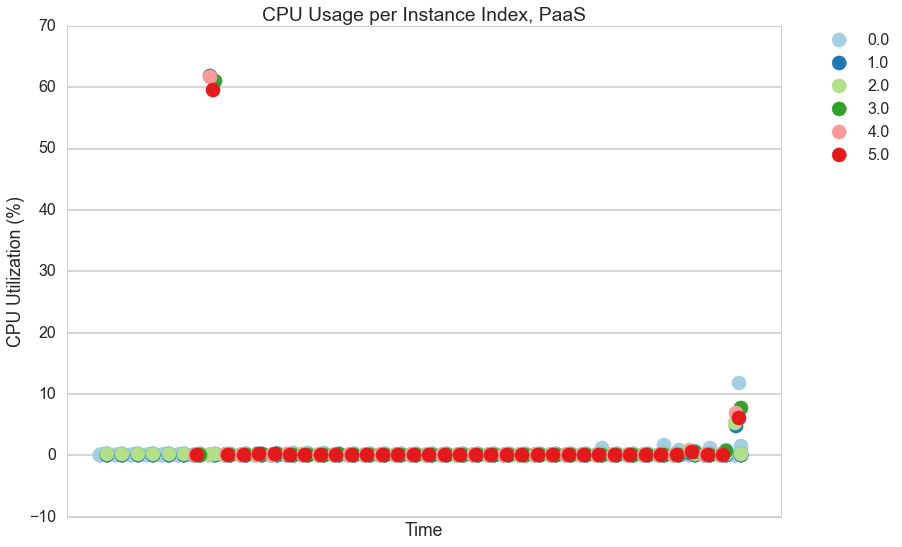

In [35]:
for name,color in index_color_list:
    sub_container=large_container_PaaSDF[large_container_PaaSDF.instance_index == name]
    ax= plt.scatter(sub_container.index.values,sub_container.cpu_percentage, color = color, label = name, s=200)
    plt.xlabel("Time")
    plt.ylabel("CPU Utilization (%)")
    plt.title("CPU Usage per Instance Index, PaaS")
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

I am likely going to remove these pairplots, I don't think it is an effective visualization - Robert

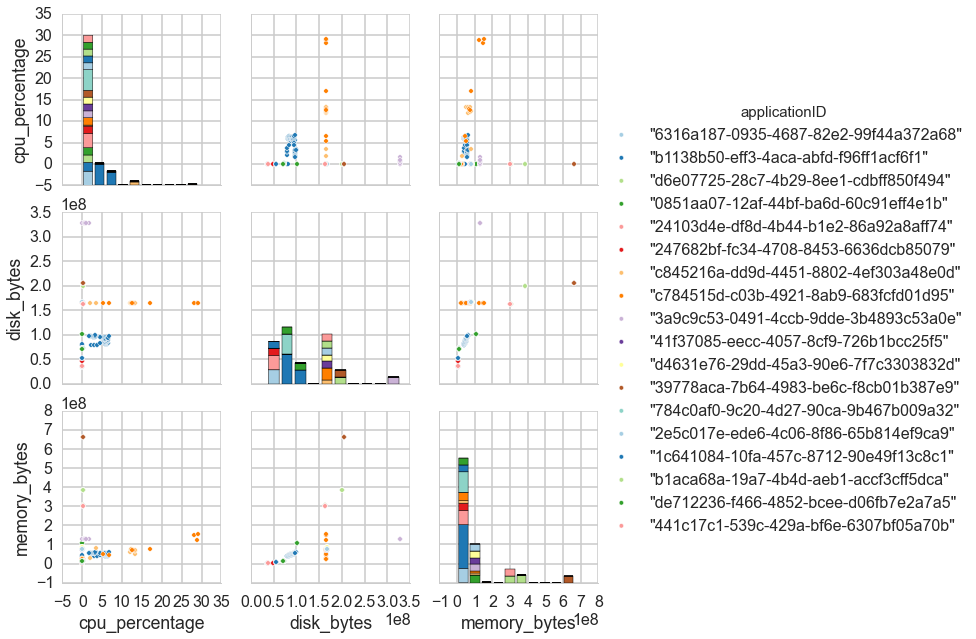

In [22]:
sns.pairplot(large_container_SaaSDF, hue="applicationID", vars = ['cpu_percentage', 'disk_bytes', 'memory_bytes'],
             palette= ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a',
                       '#ffff99','#b15928','#8dd3c7'], markers = 'o', size=3)

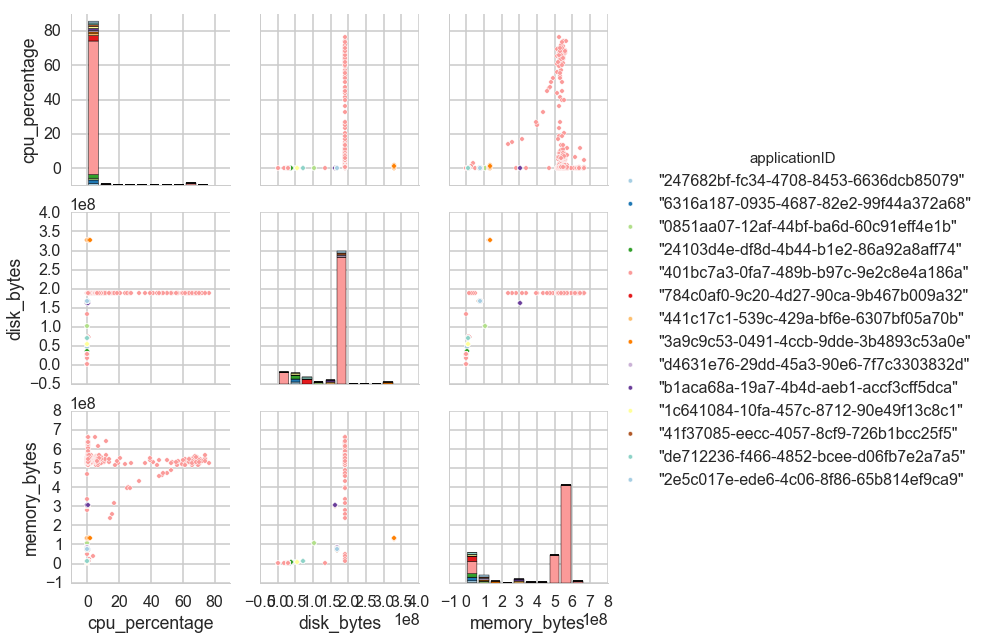

In [36]:
sns.pairplot(large_container_PaaSDF, hue="applicationID", vars = ['cpu_percentage', 'disk_bytes', 'memory_bytes'],
             palette= ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a',
                       '#ffff99','#b15928','#8dd3c7'], markers = 'o', size=3)

### Understanding the Geography of Datacenters

Datacenters are owned and operated globally by a number of companies.  We use the [datacenters.csv](https://raw.githubusercontent.com/client9/ipcat/master/datacenters.csv) provided by [https://github.com/client9/ipcat](https://github.com/client9/ipcat).
 This provides us with several thousand IPv4 address ranges that correspond to datacenters, co-location centers, shared and virtual webhosting providers.  We then use the [freegeoip.net](http://freegeoip.net) service to take these IP addresses one by one and discover the geographic coordinates for each. This will give us an approximate location for all datacenters represented in the original dataset.  We then combine and write that integrated set of data to a csv file for use in Tableau.

In [9]:
# CAUTION: this can take around 30 minutes to run.  
# Please just load the /data/datacenters_geo.csv that was generated from this code  

from time import sleep
from urllib2 import urlopen
from contextlib import closing
import json

"""
Function
--------
geo_from_ip

Inputs
------
datacenter_df: a dataframe containing datacenter IP address information,
e.g. ip_start, ip_end, datacenter_provider, provider_url
   
Returns
-------

A Pandas dataframe containing the original information plus the city, region_name, 
country_name & zip_code for the related IP address. 


Notes
-----
See description and example above.
"""

def geo_from_ip(ip):

    latitude = ''
    longitude = ''
    city = ''
    region = ''
    country = ''
    country_code = ''
    time_zone = ''
    
    
    url = 'http://freegeoip.net/json/' + ip
    #print ip
    try:
        with closing(urlopen(url)) as response:
            location = json.loads(response.read())
            #print(location)
            latitude = location['latitude']
            longitude = location['longitude']
            time_zone = location['time_zone']
            country_code = location['country_code']
            country = location['country_name']
            city = location['city']
            region = location['region_name']

    except:
        print("Location could not be determined automatically") 
        
    sleep(0.1) # Be nice to the folks at freegeoip.net

    return latitude, longitude, city, region, country, country_code, time_zone 
  
       
dcdf = pd.read_csv('./data/datacenters.csv')
#dcdf = dcdf.head(5) # <-- Uncomment this line to create only a portion of the entire dataset
dcdf['latitude'], dcdf['longitude'], dcdf['city'], dcdf['region'], dcdf['country'], dcdf['country_code'], dcdf['time_zone'] = zip(*dcdf['ip_start'].map(geo_from_ip))

dcdf.to_csv("data/datacenters_geo.csv", encoding="utf-8")
dcdf.head(5)

,ip_start,ip_end,datacenter_provider,provider_url,latitude,longitude,city,region,country,country_code,time_zone
0,5.9.0.0,5.9.255.255,Hetzner Online AG,http://www.hetzner.de/,51.0000,9.0000,,,Germany,DE,
1,5.10.64.0,5.10.127.255,SoftLayer,http://www.softlayer.com/,52.3740,4.8897,Amsterdam,North Holland,Netherlands,NL,Europe/Amsterdam
2,5.34.182.0,5.34.183.255,UA Servers,https://itldc.com/,50.4500,30.5233,,,Ukraine,UA,
3,5.34.240.0,5.34.244.255,webexxpurts.com,http://webexxpurts.com/,59.3294,18.0686,,,Sweden,SE,Europe/Stockholm
4,5.34.247.0,5.34.247.255,webexxpurts.com,http://webexxpurts.com/,38.0000,-97.0000,,,United States,US,


### Visualizing an interactive map of the world's datacenters

Combining the datasets gives us geolocation enough data to use Tableau build an interactive map of the datacenters around the world that are public listed.  We also added tooltips to the map to allow the user to drill into the data.  To see our map in action click [here to go to our Tableau Public map](https://public.tableau.com/views/Datacentersaroundtheworld/Datacentermap?:embed=y&:display_count=yes&:showTabs=y)


A static image of the map looks like this:
![Datacenters around the world](http://harvard-team-pivot.github.io/elastic-compute/visualizations/datacenters-map.png "datacenters around the world")



## Final Analysis

## Storytelling and Designing the Elastic Compute Website

### Making the Video and Presentation Deck
We wanted to tell a compelling story through our website by first helping the average user navigate the technical morass that the **third platform** is mired in.  

In order to do that effectively we needed to build an animated deck in Keynote to help drive the points that we felt we important to promote understanding.  We went through several iterations of the Keynote deck and ruthless cut about 50% of the original deck to ensure we really were getting our message down to only the essential points.  

The original deck can be downloaded from the GitHub site here, as [elastic-compute.key](https://github.com/harvard-team-pivot/elastic-compute/blob/master/presentation/elastic-compute.key?raw=true).  You'll notice that we set many slides to "skip" and in the end only present the basics.

We spent alot of time getting the story right and used the speaker notes in the deck to do so.  The initial version was coming out a bit to dark and forboding, so we made a decision to focus instead on a postive angle with a hopeful narration that we hope in the end mixed in a bit of humor to lighten the serious nature of the material.

![](http://harvard-team-pivot.github.io/elastic-compute/img/keynote-build-out.png)

After it we had what we thought was a good deck with animation and story in the speaker notes, we then proceeded to record the narration.  The focus was on keeping our voice upbeat and enunciate.  And to do it quickly since we only had 2 minutes to introduce our story to get people to care enough to dig into our research over at our website.

The video is hosted on YouTube at [https://youtu.be/9Hat1SxM8jU](https://youtu.be/9Hat1SxM8jU)

Here's a screenshot to show what it looks like on YouTube:

![](http://harvard-team-pivot.github.io/elastic-compute/img/elastic-compute-video.png)

### Making the Website

We used GitHub to host the website at [http://harvard-team-pivot.github.io/elastic-compute](http://harvard-team-pivot.github.io/elastic-compute); but, we decided against using the standard page templates the offer.  We thought that designing our own would have a more professional outcome.

First we started with a simple whiteboard and drew out the basic concept, like so:

![](http://harvard-team-pivot.github.io/elastic-compute/img/landing-page-sketch.png)

We then went through and documented in a pdf what we wanted each element to do to help create a pleasing and professional User Experience.  That document can be found here, as [Elastic Compute - Web Design](http://harvard-team-pivot.github.io/elastic-compute/pdf/elastic-compute-web-design.pdf)


We wanted a strong "hook" to draw vistors deeper into our page content.  So we lead with an odd question... "What would you do with a spare terawatt?".  It's not everyday that someone will ask you about that.  We used a lead background image that pulls the eye onward through a great, green mountain valley to the hint of a sunset and a new dawn. 

Once we had vistor attention we wanted to draw them down the page immediately to the video in the next section.  We gave it a lead line that really try to limit the committment of the visitors time by advertising the it is a short 2-minute breakdown of our premise and project.  We felt that was a strong enough reason to keep eyes on the site and scrolling downward to the rest of the more detailed story we wanted to invest them in.

![](http://harvard-team-pivot.github.io/elastic-compute/img/website-screenshot.png)


We organized the areas of the website "below-the-fold" to get vistors to scroll down.  We added pleasing imagery that related to our message interleaved with low-tax, low cognitive load visualizations like our interactive world map with all of the datacenters shown with tooltip details that are interesting about each datacenter.  


![](http://harvard-team-pivot.github.io/elastic-compute/img/website-screenshot-2.png)


We gradually increase the density of technical nature of the text and visualizations as the vistor scrolls down the page in order to acclimate them as the read.  We don't want to shock anyone with a deep dive into the benefits, including the electrical efficiency that can be gained by our research.

![](http://harvard-team-pivot.github.io/elastic-compute/img/website-screenshot-3.png)

And then finally, we point the user to the process book to allow them to dive into the deep end.




## Managing the Project

Since our team members travelled and we never going to see one another in person we had to make some crucial decisions upfront about how to manage the workload, have meeting and discuss the project.

To manage the project tasks we took an agile approach and create all of the thing that needed to get done in the free Pivotal Tracker web app.  Our project tracker is publically available at [https://www.pivotaltracker.com/n/projects/1480380](https://www.pivotaltracker.com/n/projects/1480380)  although to see the tasks we worked through you'll want to look at the "Done" tab.  Tracker allowed us to evenly estimate and balance the workload among our team members and to let one another know as we made progress on our individual tasks.

![](http://harvard-team-pivot.github.io/elastic-compute/img/tracker-screenshot.png)

To communicate we used Slack at [http://cs109office.slack.com](http://cs109office.slack.com) which is generally used for office hours for remote students.  There we created our own private channel named "team-pivot".  If you'd like access to see all of our conversations as we built this project please send one of us a note and we will be glad to add you.

We built an integration between Tracker and Slack that allowed the whole team to see as Tracker task were moving through the pipeline toward completion.  Ultimately, another member of the team who did not work on the task would have to "accept" or "reject" the work to ensure that we had a double-check in place to stay on track.


![](http://harvard-team-pivot.github.io/elastic-compute/img/slack-example.png)

Additionally we held weekly meetings that became more frequent as the project deadline neared using Google Hangouts.

